In [2]:
from google.colab import files
files.upload()  # kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shreyadavvvv","key":"b9d37ea44737a0eadc4bbf415b0de255"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d hrithiqgupta/flipkart-product-reviews-for-sentient-analysis

# Unzip
!unzip flipkart-product-reviews-for-sentient-analysis.zip


Dataset URL: https://www.kaggle.com/datasets/hrithiqgupta/flipkart-product-reviews-for-sentient-analysis
License(s): unknown
  0% 0.00/3.89M [00:00<?, ?B/s]
100% 3.89M/3.89M [00:00<00:00, 1.33GB/s]
Archive:  flipkart-product-reviews-for-sentient-analysis.zip
  inflating: flipkart_product.csv    


In [5]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("flipkart_product.csv")
df.head()


,ProductName,Price,Rate,Review,Summary
0,Candes 12 L Room/Personal Air Cooler?�?�(White...,"�??3,999",5,Super!,Great cooler.. excellent air flow and for this...
1,Candes 12 L Room/Personal Air Cooler?�?�(White...,"�??3,999",5,Awesome,Best budget 2 fit cooler. Nice cooling
2,Candes 12 L Room/Personal Air Cooler?�?�(White...,"�??3,999",3,Fair,The quality is good but the power of air is de...
3,Candes 12 L Room/Personal Air Cooler?�?�(White...,"�??3,999",1,Useless product,Very bad product it's a only a fan
4,Candes 12 L Room/Personal Air Cooler?�?�(White...,"�??3,999",3,Fair,Ok ok product


In [13]:
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#','', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


# Drop rows where 'Rate' or 'cleaned_text' is missing
df = df[['cleaned_text', 'Rate']].dropna()

# Convert Rate to numeric (will handle string types like '5', '4', etc.)
df['Rate'] = pd.to_numeric(df['Rate'], errors='coerce')

# Drop any rows where conversion failed (e.g., non-numeric values)
df = df.dropna(subset=['Rate'])

# Remove neutral ratings (e.g., 3 stars)
df = df[df['Rate'] != 3]

# Map: 1-2 => 0 (Negative), 4-5 => 1 (Positive)
df['Sentiment'] = df['Rate'].apply(lambda x: 1 if x > 3 else 0)


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X = tfidf.fit_transform(df['cleaned_text'])
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [15]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

Accuracy: 0.9719846145014065

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.81      0.90      5168
           1       0.97      1.00      0.98     29670

    accuracy                           0.97     34838
   macro avg       0.98      0.91      0.94     34838
weighted avg       0.97      0.97      0.97     34838



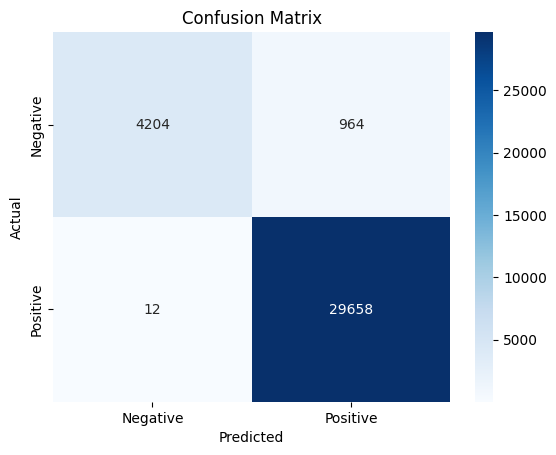

In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
